# Import needed modules

In [2]:
import os
import time
import shutil
import pathlib
import itertools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [1]:
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels

def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

def split_data(data_dir):
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### Function to generate images from dataframe

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):

    img_size = (224, 224)
    channels = 3
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)


    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size


    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)


    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [5]:
def show_images(gen):


    g_dict = gen.class_indices        
    classes = list(g_dict.keys())    
    images, labels = next(gen)        


    length = len(labels)       
    sample = min(length, 25)    

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255      
        plt.imshow(image)
        index = np.argmax(labels[i]) 
        class_name = classes[index]     
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [6]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience 
        self.stop_patience = stop_patience
        self.threshold = threshold 
        self.factor = factor 
        self.batches = batches
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch 

        self.count = 0 
        self.stop_count = 0
        self.best_epoch = 1   
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 
        self.lowest_vloss = np.inf 
        self.best_weights = self.model.get_weights() 
        self.initial_weights = self.model.get_weights()   


    def on_train_begin(self, logs= None):
        msg = 'Do you want model asks you to halt the training [y/n] ?'
        print(msg)
        ans = input('')
        if ans in ['Y', 'y']:
            self.ask_permission = 1
        elif ans in ['N', 'n']:
            self.ask_permission = 0

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)


        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')


        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')

    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()



    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) 
        current_lr = lr
        acc = logs.get('accuracy')  
        v_acc = logs.get('val_accuracy')  
        loss = logs.get('loss') 
        v_loss = logs.get('val_loss') 
        if acc < self.threshold:
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc 
            if acc > self.highest_tracc: 
                self.highest_tracc = acc 
                self.best_weights = self.model.get_weights() 
                self.count = 0 
                self.stop_count = 0 
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  

            else:
                
                if self.count >= self.patience - 1:
                    lr = lr * self.factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                    self.count = 0 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 

        else: 
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss:
                self.lowest_vloss = v_loss 
                self.best_weights = self.model.get_weights()
                self.count = 0
                self.stop_count = 0
                self.best_epoch = epoch + 1 
            else: 
                if self.count >= self.patience - 1:
                    lr = lr * self.factor 
                    self.stop_count = self.stop_count + 1 
                    self.count = 0 
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) 
                else:
                    self.count = self.count + 1 

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1:
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True 

        else:
            if self.ask_epoch != None and self.ask_permission != 0:
                if epoch + 1 >= self.ask_epoch:
                    msg = 'enter H to halt training or an integer for number of epochs to run then ask again'
                    print(msg)

                    ans = input('')
                    if ans == 'H' or ans == 'h':
                        msg = f'training has been halted at epoch {epoch + 1} due to user input'
                        print(msg)
                        self.model.stop_training = True 

                    else:
                        try:
                            ans = int(ans)
                            self.ask_epoch += ans
                            msg = f' training will continue until epoch {str(self.ask_epoch)}'
                            print(msg)
                            msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
                            print(msg)

                        except Exception:
                            print('Invalid')

#### **Function to plot history of training**

In [7]:
def plot_training(hist):

    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()


#### **Function to create Confusion Matrix**

In [8]:
def plot_confusion_matrix(cm, classes, normalize= False, title= 'Confusion Matrix', cmap= plt.cm.Blues):
	plt.figure(figsize= (10, 10))
	plt.imshow(cm, interpolation= 'nearest', cmap= cmap)
	plt.title(title)
	plt.colorbar()

	tick_marks = np.arange(len(classes))
	plt.xticks(tick_marks, classes, rotation= 45)
	plt.yticks(tick_marks, classes)

	if normalize:
		cm = cm.astype('float') / cm.sum(axis= 1)[:, np.newaxis]
		print('Normalized Confusion Matrix')

	else:
		print('Confusion Matrix, Without Normalization')

	print(cm)

	thresh = cm.max() / 2.
	for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
		plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

	plt.tight_layout()
	plt.ylabel('True Label')
	plt.xlabel('Predicted Label')

# **Model Structure**

#### **Start Reading Dataset**

In [11]:
data_dir = r"/Users/vaibhavmk/Downloads/MarineData"
try:
    
    train_df, valid_df, test_df = split_data(data_dir)
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Found 5043 validated image filenames belonging to 23 classes.
Found 630 validated image filenames belonging to 23 classes.
Found 631 validated image filenames belonging to 23 classes.


#### **Display Image Sample**

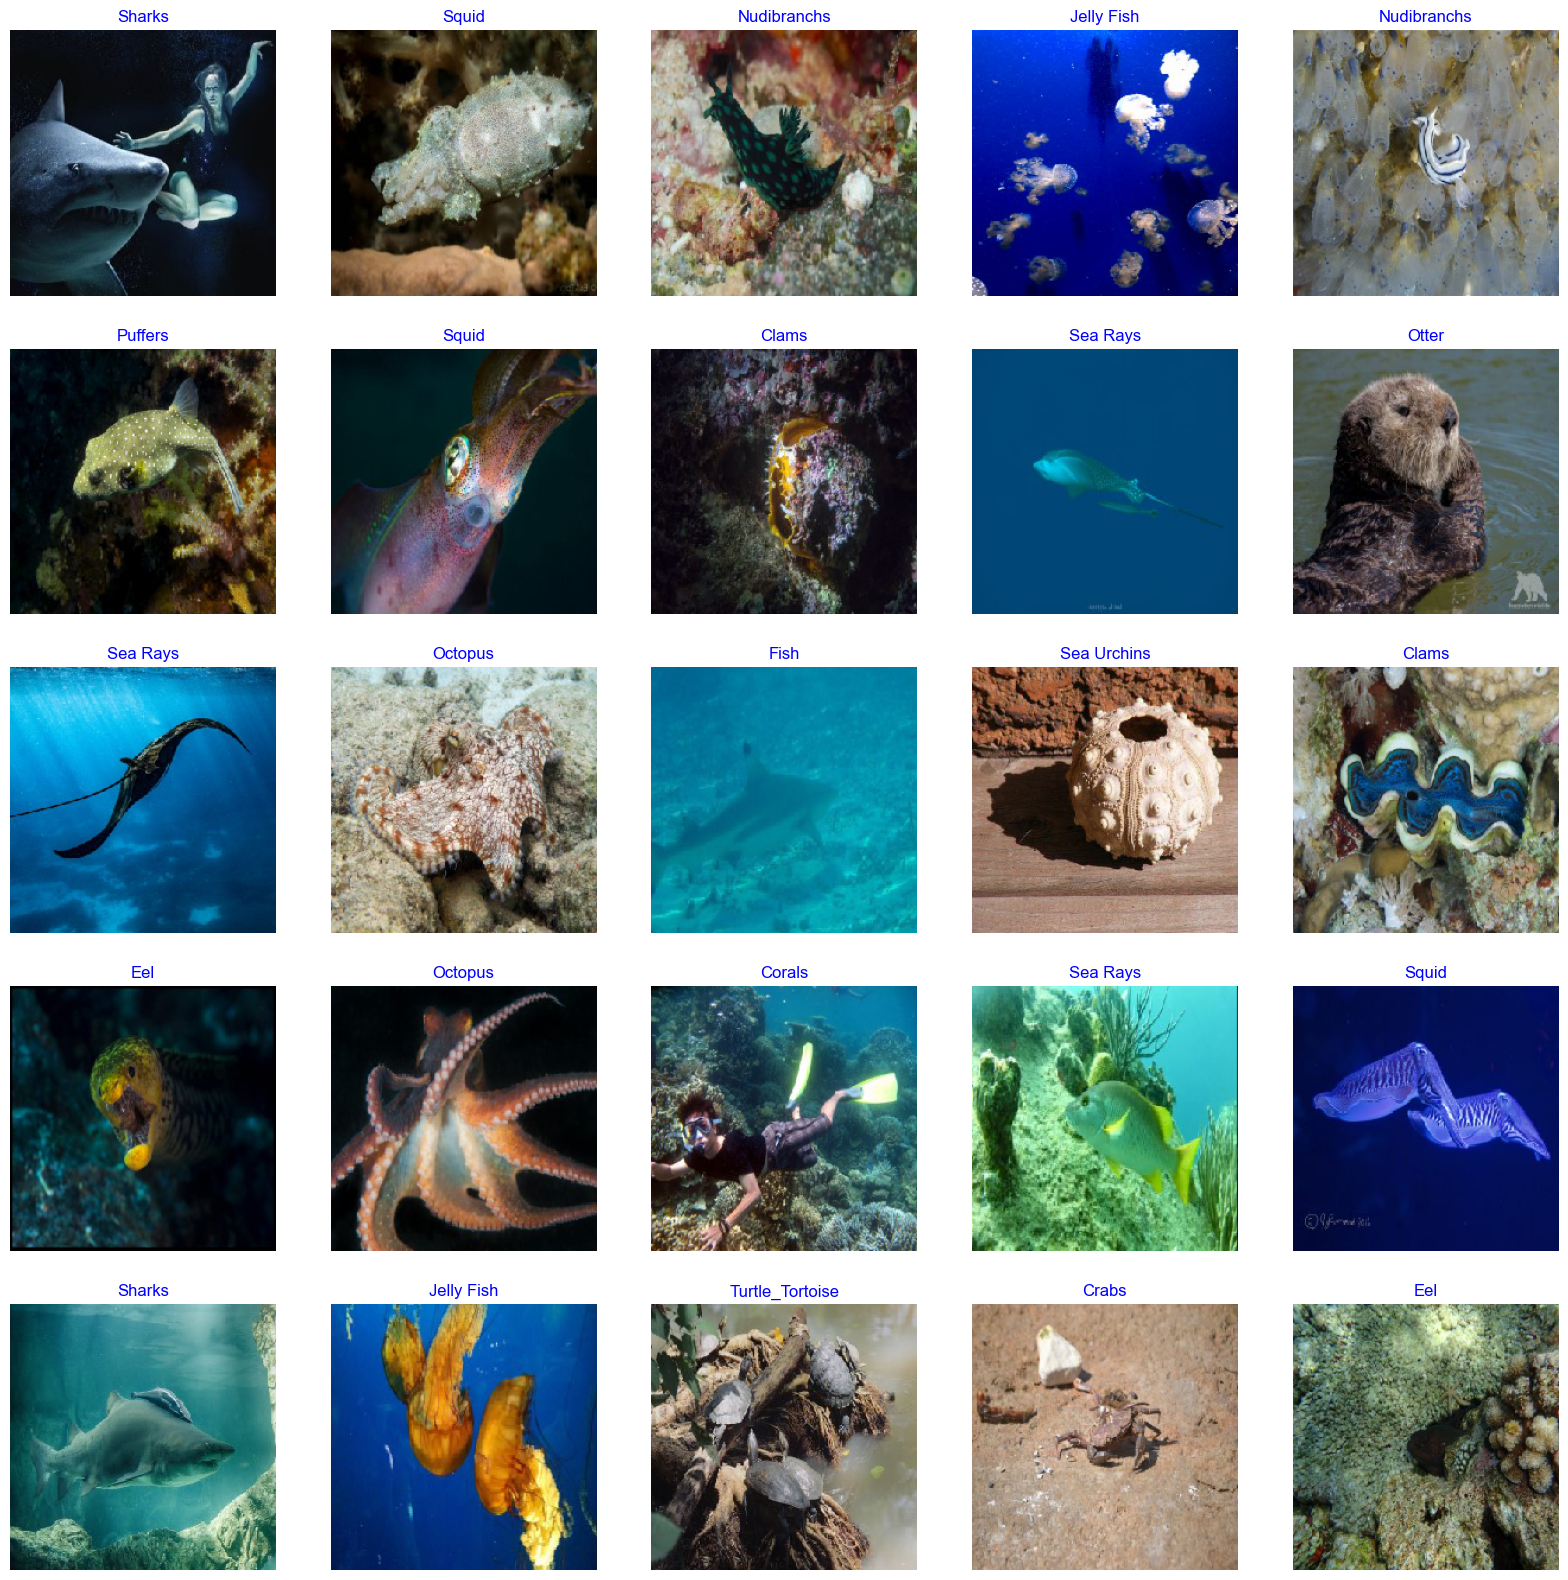

In [12]:
show_images(train_gen)

#### **Generic Model Creation**

In [13]:
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys()))

base_model = tf.keras.applications.efficientnet.EfficientNetB5(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb5 (Functional  (None, 2048)              28513527  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 23)                5911      
                                                                 
Total params: 29052174 (110.83 MB)
Trainable params: 288

#### **Set Callback Parameters**

In [18]:
batch_size = 40 
epochs = 5  
patience = 1  
stop_patience = 3  
threshold = 0.9   
factor = 0.5  
ask_epoch = 5  
batches = int(np.ceil(len(train_gen.labels) / batch_size))   

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### **Train model**

In [19]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

Do you want model asks you to halt the training [y/n] ?
y
 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /5      4.899   86.714   4.62470  78.571   0.00100  0.00100  accuracy     0.00   1213.00 
 2 /5      3.896   89.193   3.78076  79.206   0.00100  0.00100  accuracy     2.86   1257.04 
 3 /5      3.091   92.980   3.17504  78.413   0.00100  0.00100  val_loss    16.02   1212.02 
 4 /5      2.504   95.340   2.77267  77.937   0.00100  0.00100  val_loss    12.67   1220.55 
 5 /5      2.086   96.669   2.40497  80.317   0.00100  0.00100  val_loss    13.26   1182.33 
enter H to halt training or an integer for number of epochs to run then ask again
h
training has been halted at epoch 5 due to user input
training elapsed time was 1.0 hours, 41.0 minutes, 52.17 seconds)


#### **Display model performance**

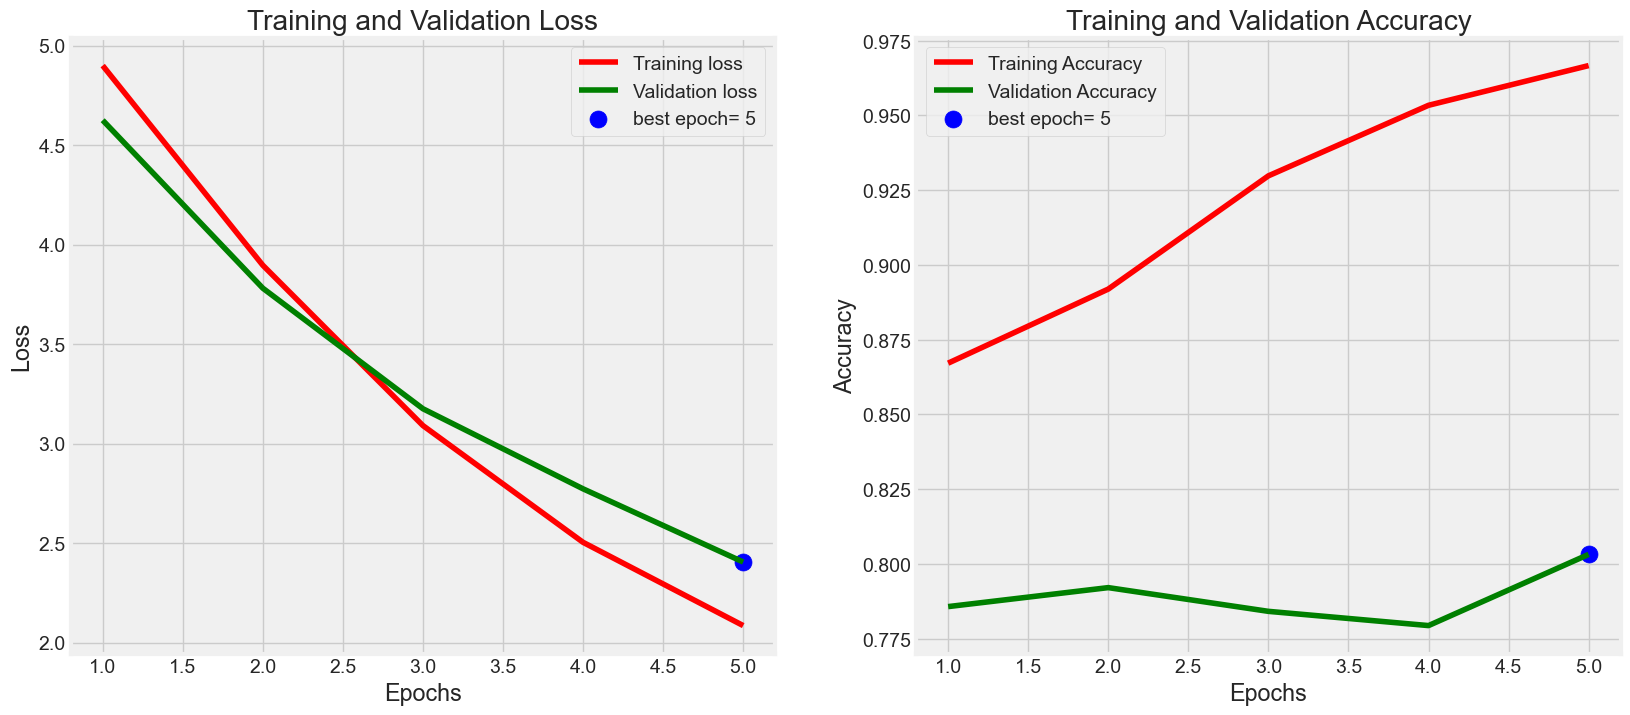

In [20]:
plot_training(history)

# **Evaluate model**

In [26]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

25/25 [==============================] - 6s 230ms/step - loss: 0.5664 - accuracy: 0.9098
Train Loss:  0.22058822214603424
Train Accuracy:  0.996999979019165
--------------------
Validation Loss:  0.5758674740791321
Validation Accuracy:  0.9169999957084656
--------------------
Test Loss:  0.5664339661598206
Test Accuracy:  0.9097872376441956


# **Get Predictions**

In [41]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[ 6  3 21 20  1 22  7  8 17 17 19  3  5 14 11  4 12  8 16  5  6 15  5 12
 18 17 17 10 19 21  7 15  2  8  7 21 10 21 13  8  1 12 15  9  3 15 14 14
  3 19 22 15  7  3 10 13  8  7  9  4 18  8  2  1 17 14  4 17 15  8  9 10
 22  8 22 21 21 20  9 22  7 14 12  3  8  6  6 15  4 21  8 12 15 17  5  9
  3 10 20  3 13 11  4 10  6 18 17 17 14 11 12 12  3  2  5  1 13  7 10  2
 15 18  1  5 14  3  2 17  0 21 15  1 21  6  4  1  0 15 11  9 18  2 17 14
  6 12  8  2 21 21  8  3 14  2  4  0 18  5  9  1  6 12 14 18  1  9 17  8
  4  6 14 22  4  1 17  3 14 17 17 10 19 10  4  3 18 18  0 21  4  8 15 20
 20 13 17 20 19  3  0  9  9 21 16 20 19 14  7 15  6  9  7  2  5  6  2 12
 19 10 19 13 17  7  5  6 15 11  6  8  3  7 14 18  0  9 14 19  7 19  9  6
  8 10 10 20 14 14  3  5 18  7 17  6  8 11  5 12 21 15 17 18  4 20  6 12
  7 13  9  1 14  4  7  1 10  2  3 11 22  9 15 10  5 19 14 11  5 19  6  0
  4  3  0  1  4  8 16 18 14 18 15 12 22 16 18 11 22 20 18 19 21 14  5  6
 21 10  9 20 12 18  3 21 12 13 14 11 13 17 21  3 13

#### **Confusion Matrics and Classification Report**

In [44]:
classes = list(g_dict.keys())

In [45]:
cm = confusion_matrix(test_gen.classes, y_pred) 

Confusion Matrix, Without Normalization
[[16  3  0  0  0  0  1  0  0  1  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 12  0  0  1  1  0  1  1  3  0  0  2  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 30  0  0  1  0  0  0  0  0  0  0  0  0  0  1  0  0  0  1  5]
 [ 0  1  0  0 18  1  0  0  0  3  0  0  1  1  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  1 16  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  1  0]
 [ 0  0  0  1  0  0 40  0  1  1  0  0  0  0  0  0  0  0  0  0  0  1  0]
 [ 0  1  0  0  0  0  0 24  0  1  0  0  0  0  0  0  0  1  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 25  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  3  0  0  1  0  0  0  1 23  0  0  0  0  0  0  0  0  0  1  1  1  0]
 [ 0  0  0  0  0  0  0  0  0  0 27  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0  0  0  0  0  0 20  0  1  0  0  1  2  0  0  0  0  0]
 [ 0  0  0  0  4  1  1  0  1  1  0  0 19  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  

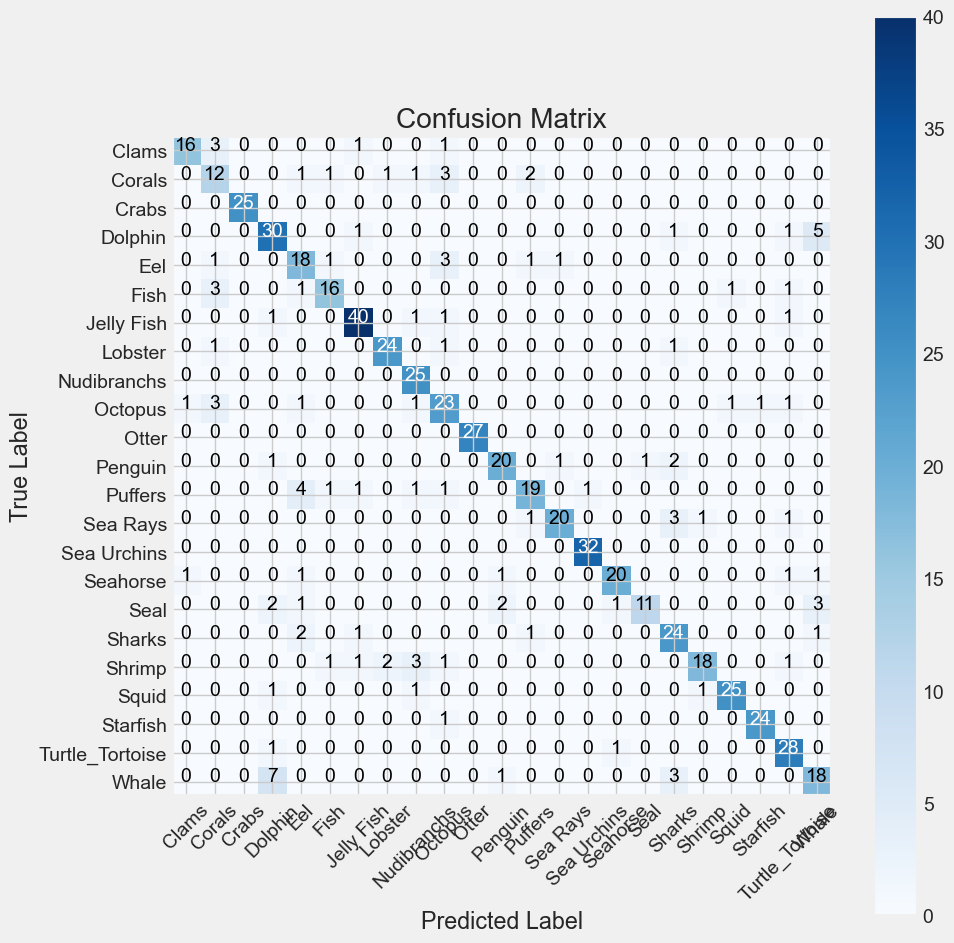

In [46]:
plot_confusion_matrix(cm= cm, classes= classes, title = 'Confusion Matrix')

In [48]:
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                 precision    recall  f1-score   support

          Clams       0.89      0.76      0.82        21
         Corals       0.52      0.57      0.55        21
          Crabs       1.00      1.00      1.00        25
        Dolphin       0.70      0.79      0.74        38
            Eel       0.62      0.72      0.67        25
           Fish       0.80      0.73      0.76        22
     Jelly Fish       0.89      0.91      0.90        44
        Lobster       0.89      0.89      0.89        27
    Nudibranchs       0.76      1.00      0.86        25
        Octopus       0.66      0.72      0.69        32
          Otter       1.00      1.00      1.00        27
        Penguin       0.83      0.80      0.82        25
        Puffers       0.79      0.68      0.73        28
       Sea Rays       0.91      0.77      0.83        26
    Sea Urchins       0.97      1.00      0.98        32
       Seahorse       0.91      0.80      0.85        25
           Seal       0.92    